In [1]:
%reload_ext autoreload
%autoreload

import glob
import os
import pathlib
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from tqdm import tqdm

matplotlib.rcParams["figure.figsize"] = (24, 8)

import mpl_hig

mpl_hig.set("whitegrid")

In [2]:
import sys

sys.path.append("..")

In [3]:
from aenet import AdaptiveElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

## Synthesize data

In [4]:
np.random.seed(42)

In [5]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

n_samples = 2000
n_features = 100
n_informative = 10
sn_ratio = 0.5

X, y, true_coef = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    coef=True,
    random_state=42,
)
noise = sn_ratio * y.std() * np.random.randn(*y.shape)
y += noise

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.5, random_state=42)

In [6]:
X_tr.shape, X_te.shape

((1000, 100), (1000, 100))

In [7]:
print("informative features:", np.count_nonzero(true_coef))

informative features: 10


In [8]:
from sklearn.metrics import r2_score

print("Maximum r2 score:", r2_score(y_true=y, y_pred=y - noise))

Maximum r2 score: 0.8033815203537972


### Fit

In [9]:
models = [LinearRegression(), ElasticNet(), AdaptiveElasticNet()]

for model in models:
    model.fit(X_tr, y_tr)
    model.y_pred = model.predict(X_te)

### R2 score

In [10]:
for model in models:
    print(model.__class__.__name__, model.score(X_te, y_te))

LinearRegression 0.7620322141413987
ElasticNet 0.6796596522987206
AdaptiveElasticNet 0.5711918364563413


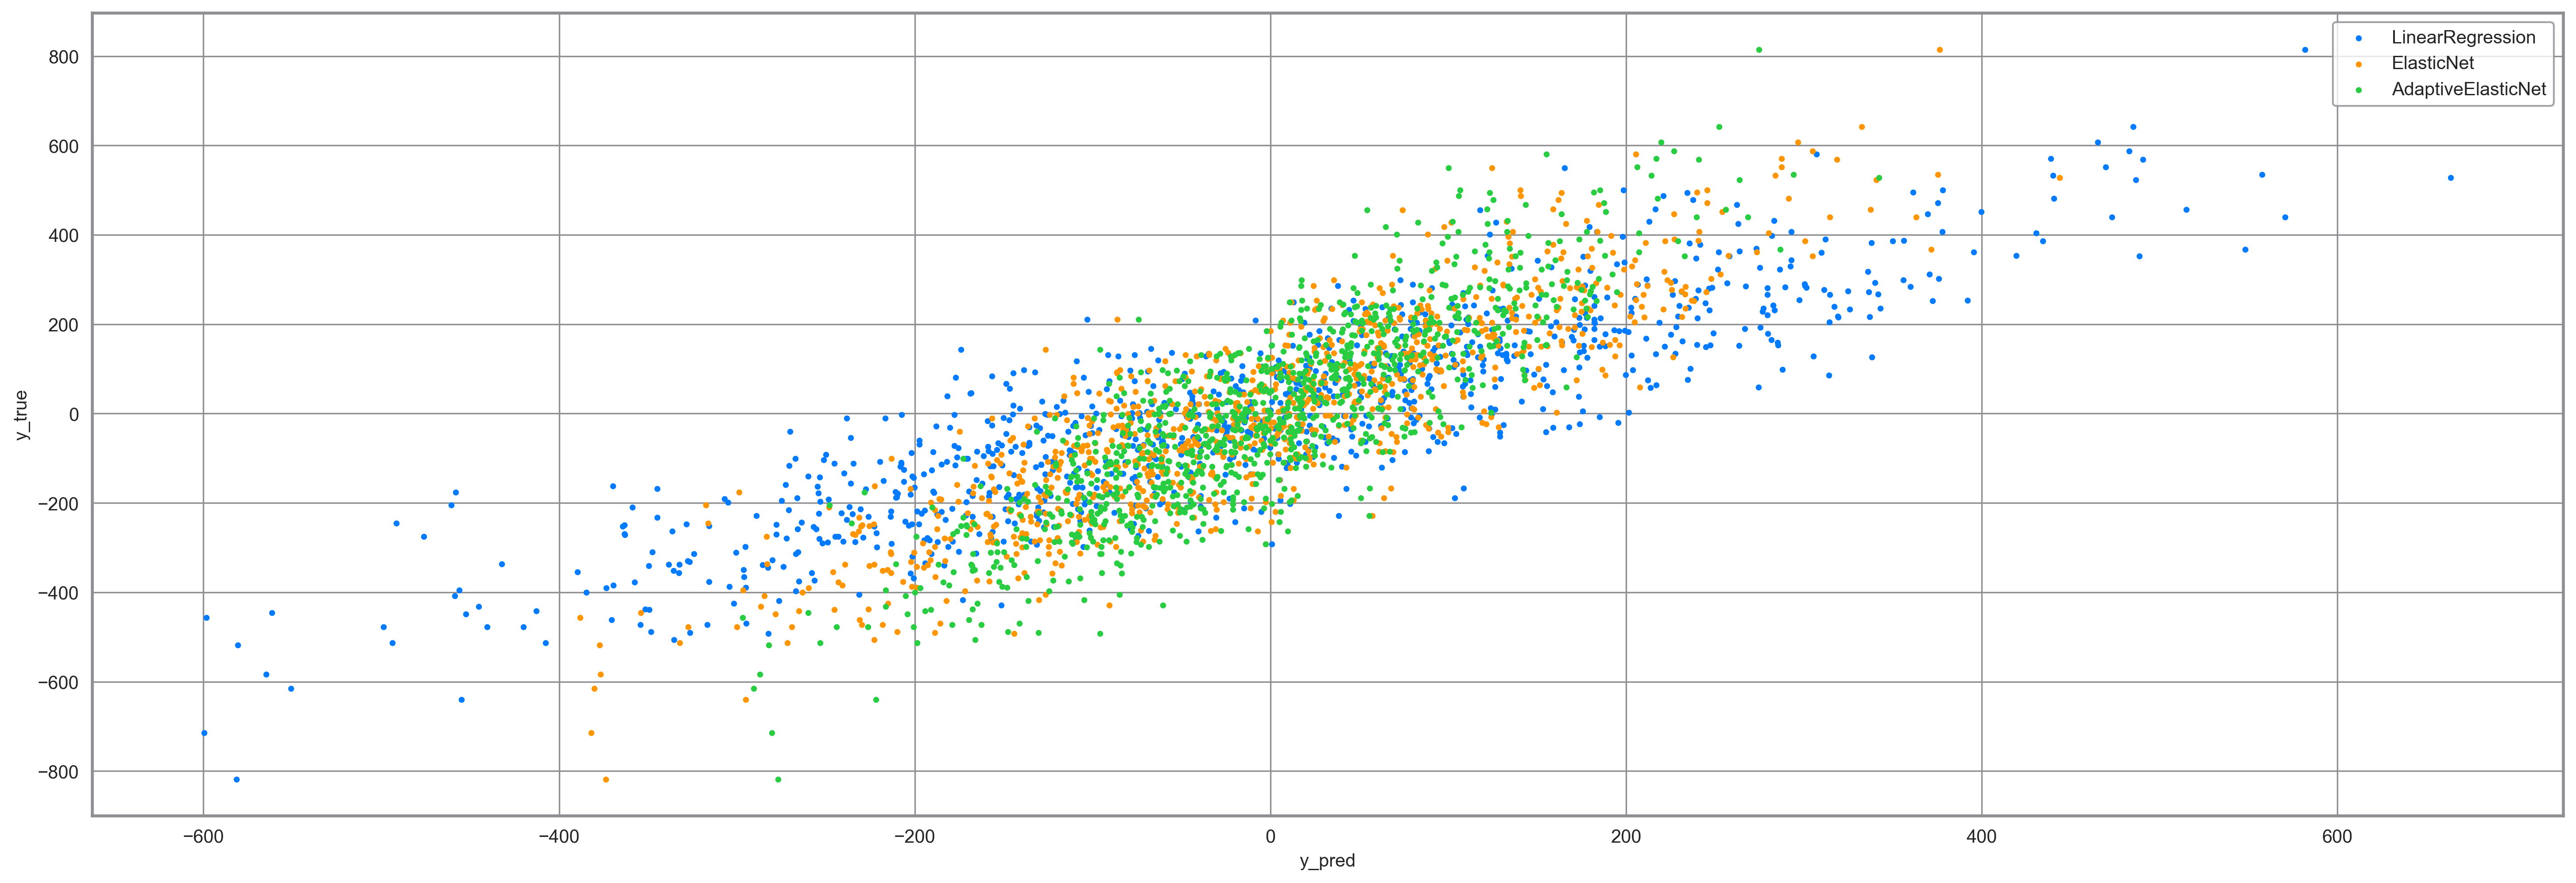

In [11]:
for model in models:
    plt.scatter(model.y_pred, y_te, label=model.__class__.__name__, s=5)

plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.legend()
plt.show()

### Coefficients

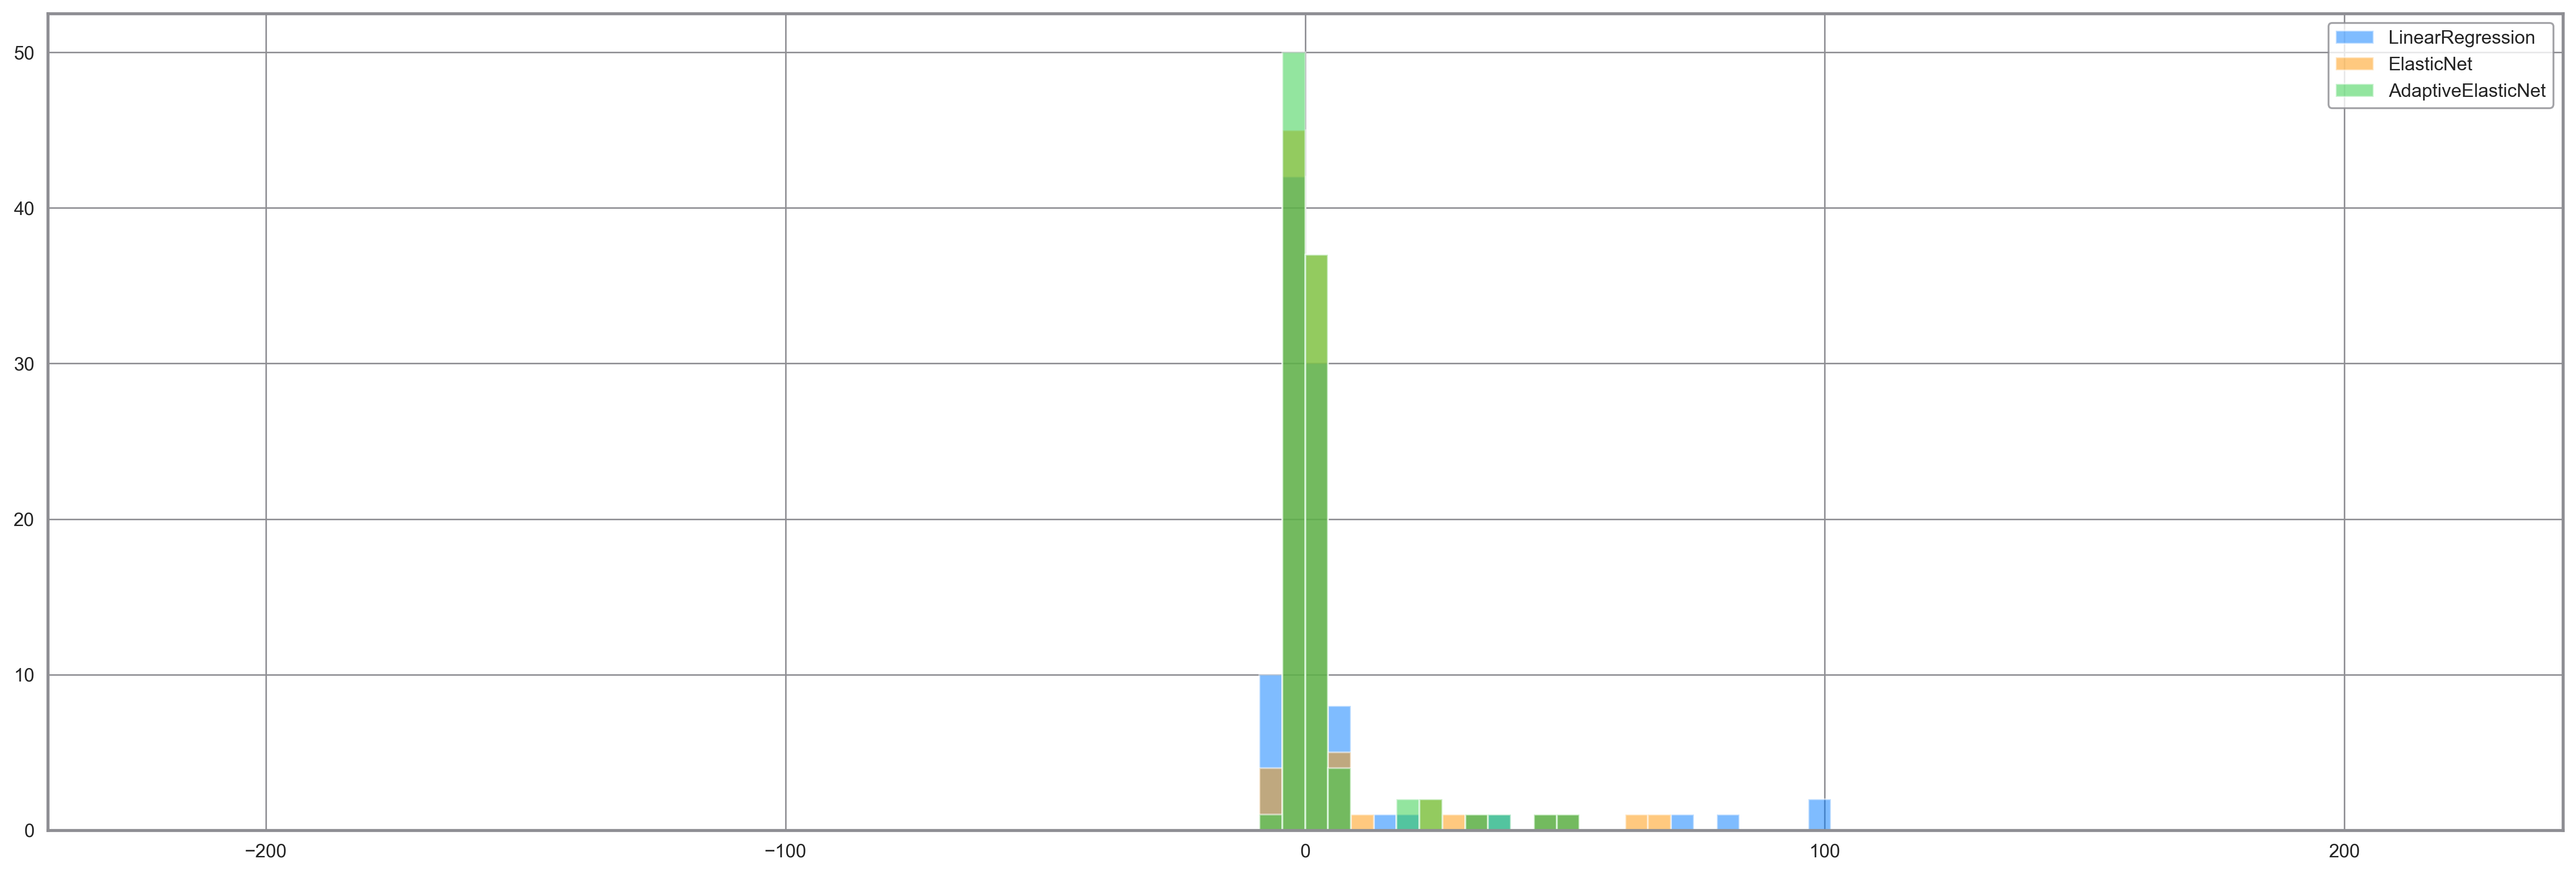

In [12]:
for model in models:
    plt.hist(
        model.coef_,
        bins=100,
        label=model.__class__.__name__,
        range=(-220, 220),
        alpha=0.5,
    )

plt.legend()
plt.show()

In [13]:
for model in models:
    nonzero = (model.coef_ != 0).astype(int)
    nonzero_true = (true_coef != 0).astype(int)
    n = np.count_nonzero(model.coef_)

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score

    a = accuracy_score(y_true=nonzero_true, y_pred=nonzero)
    f = f1_score(y_true=nonzero_true, y_pred=nonzero)
    c = confusion_matrix(y_true=nonzero_true, y_pred=nonzero)

    print(a, f, n)
    print(c)

0.1 0.18181818181818182 100
[[ 0 90]
 [ 0 10]]
0.17 0.19417475728155342 93
[[ 7 83]
 [ 0 10]]
0.16 0.1923076923076923 94
[[ 6 84]
 [ 0 10]]


### Oracle

In [14]:
from sklearn.metrics import mean_squared_error

print("Coef errors:")

for model in models:
    coef_error = mean_squared_error(y_true=true_coef, y_pred=model.coef_)
    print(model.__class__.__name__, coef_error)

Coef errors:
LinearRegression 12.013947119250775
ElasticNet 54.853692077859456
AdaptiveElasticNet 109.01452896573066


In [15]:
def score(model, sn_ratio=0.5, train_size=100, r_informative=0.1, score="r2"):
    n_features = 100
    n_informative = int(n_features * r_informative)
    X, y, true_coef = make_regression(
        n_samples=1000,
        n_features=n_features,
        n_informative=n_informative,
        coef=True,
        random_state=42,
    )
    y += sn_ratio * y.std() * np.random.randn(*y.shape)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=train_size, random_state=42
    )
    model.fit(X_tr, y_tr)
    if score == "r2":
        return model.score(X_te, y_te)
    if score == "coeferror":
        return mean_squared_error(y_true=true_coef, y_pred=model.coef_)

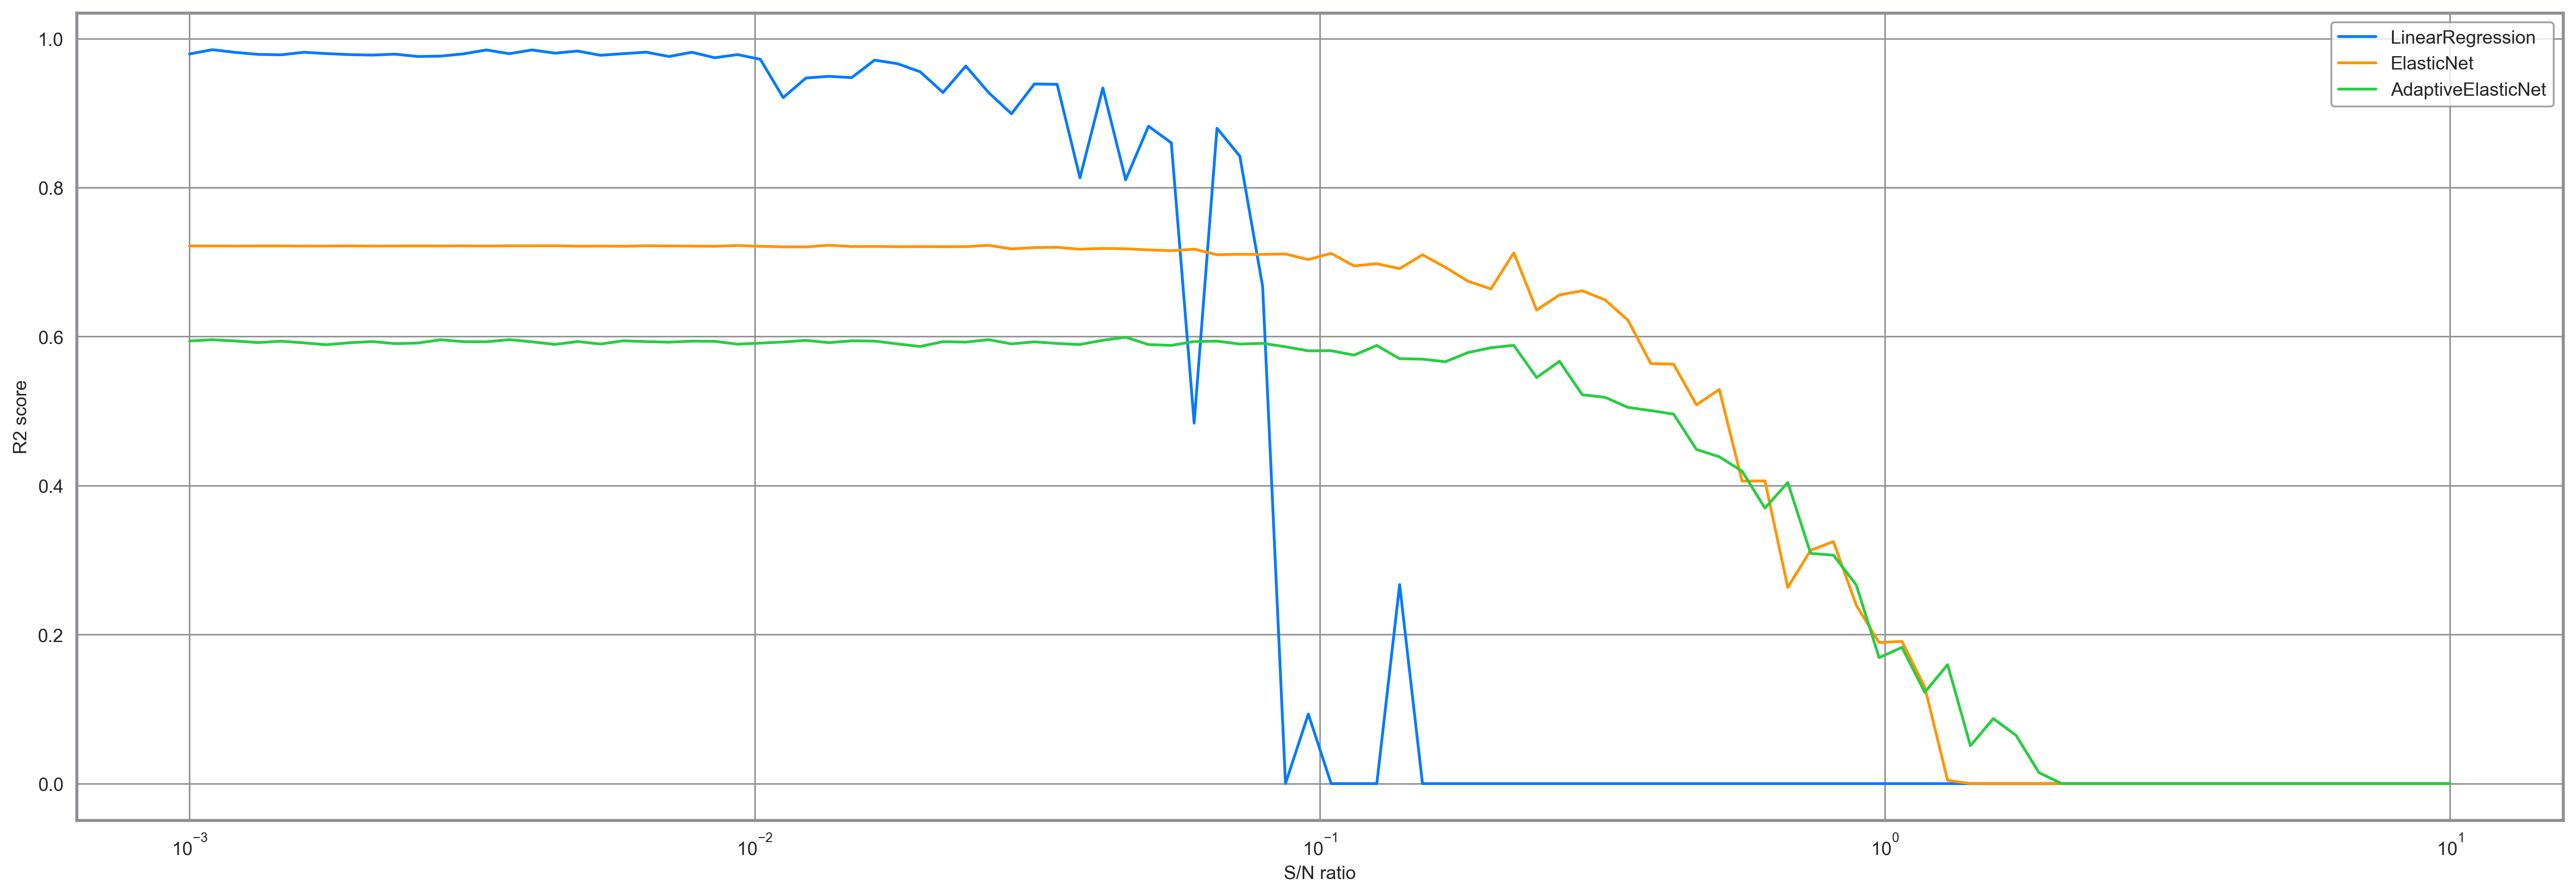

In [16]:
for model in models:
    sn_ratios = np.logspace(-3, 1, 100)
    r2 = [score(model, sn_ratio=sn_ratio, score="r2") for sn_ratio in sn_ratios]
    r2 = np.maximum(0, r2)
    plt.plot(sn_ratios, r2, label=model.__class__.__name__)

plt.xscale("log")
plt.legend()
plt.xlabel("S/N ratio")
plt.ylabel("R2 score")
plt.show()

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


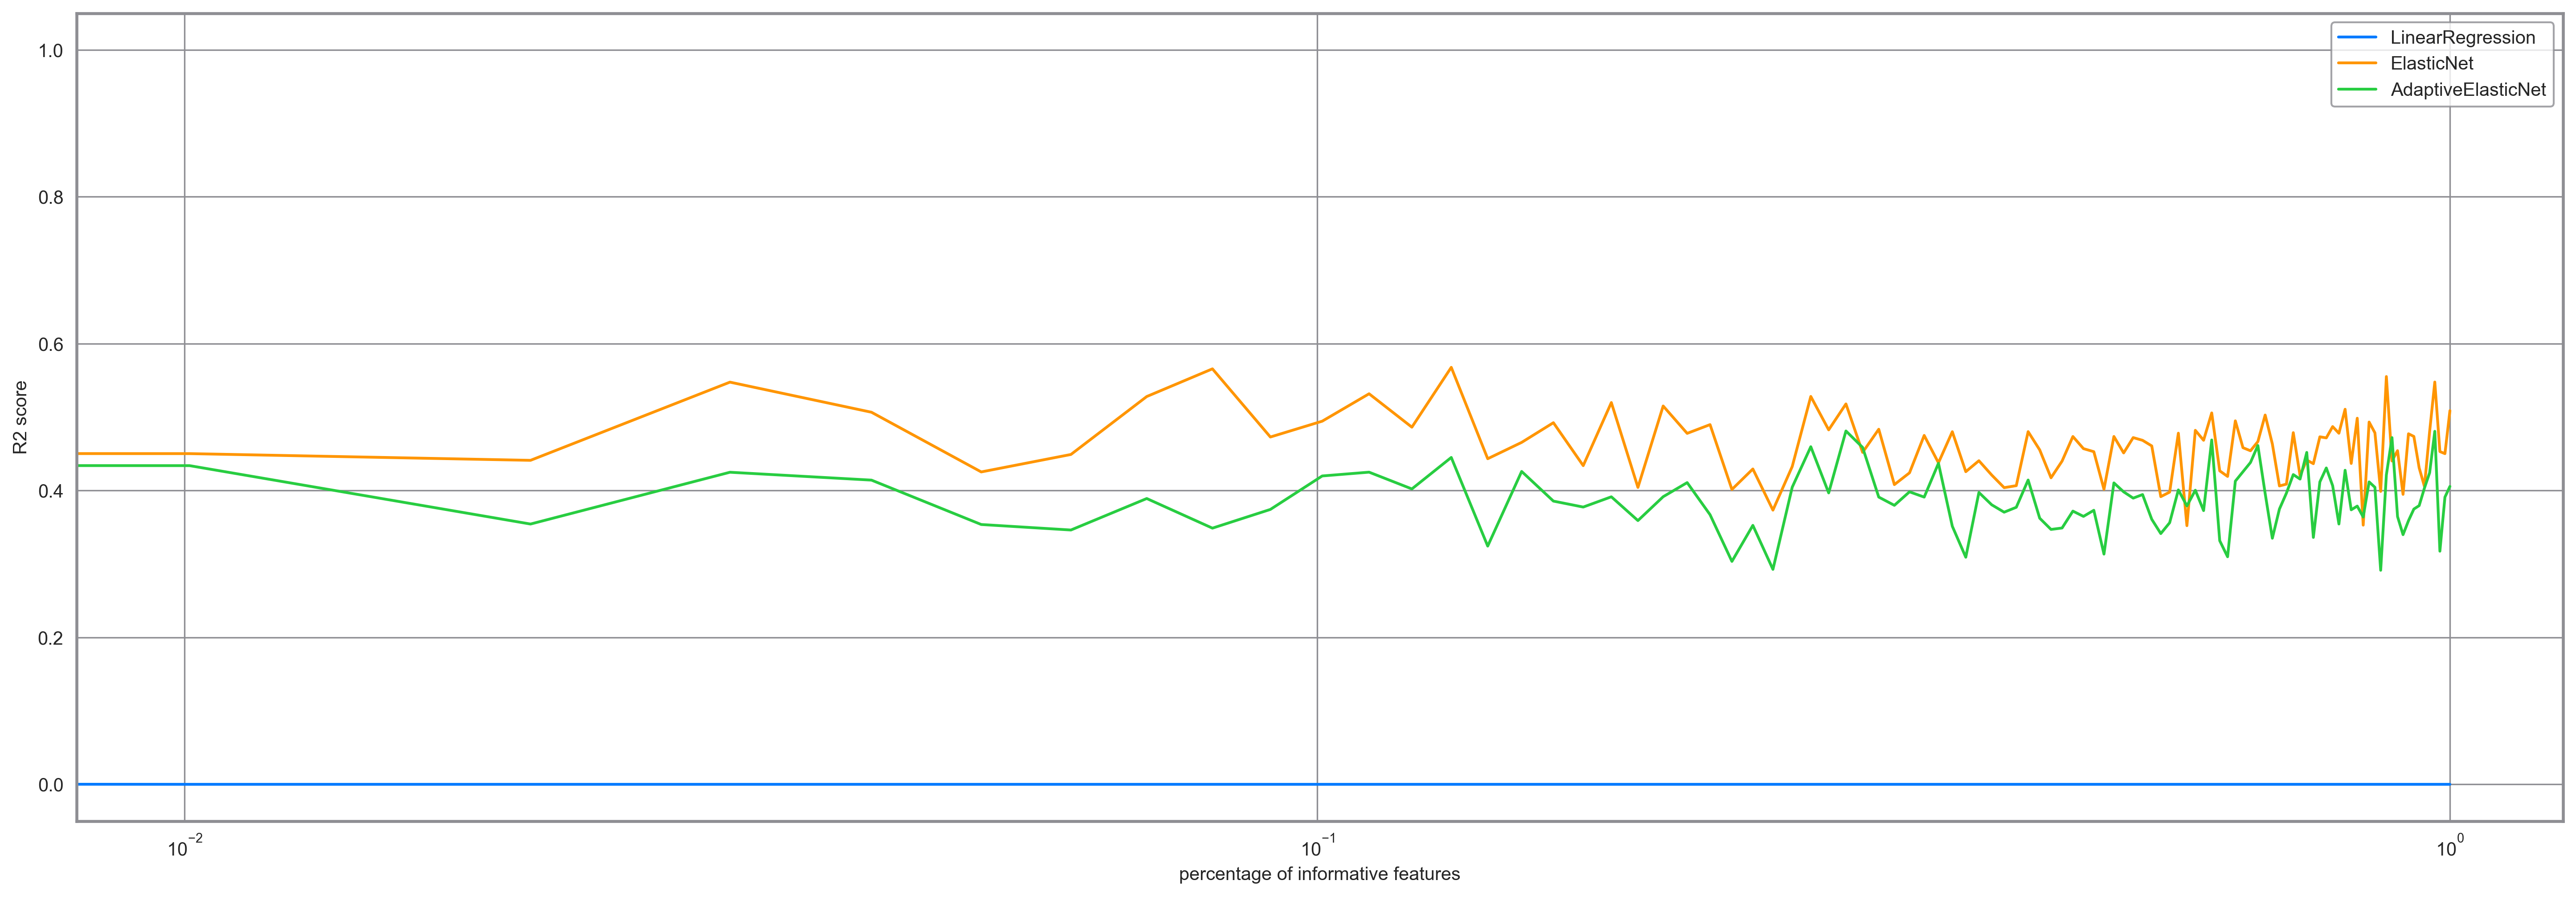

In [17]:
for model in models:
    r_informatives = np.linspace(0, 1, 100)
    r2 = [score(model, r_informative=x, score="r2") for x in r_informatives]
    r2 = np.maximum(0, r2)
    plt.plot(r_informatives, r2, label=model.__class__.__name__)

plt.xscale("log")
plt.legend()
plt.xlabel("percentage of informative features")
plt.ylabel("R2 score")
plt.show()

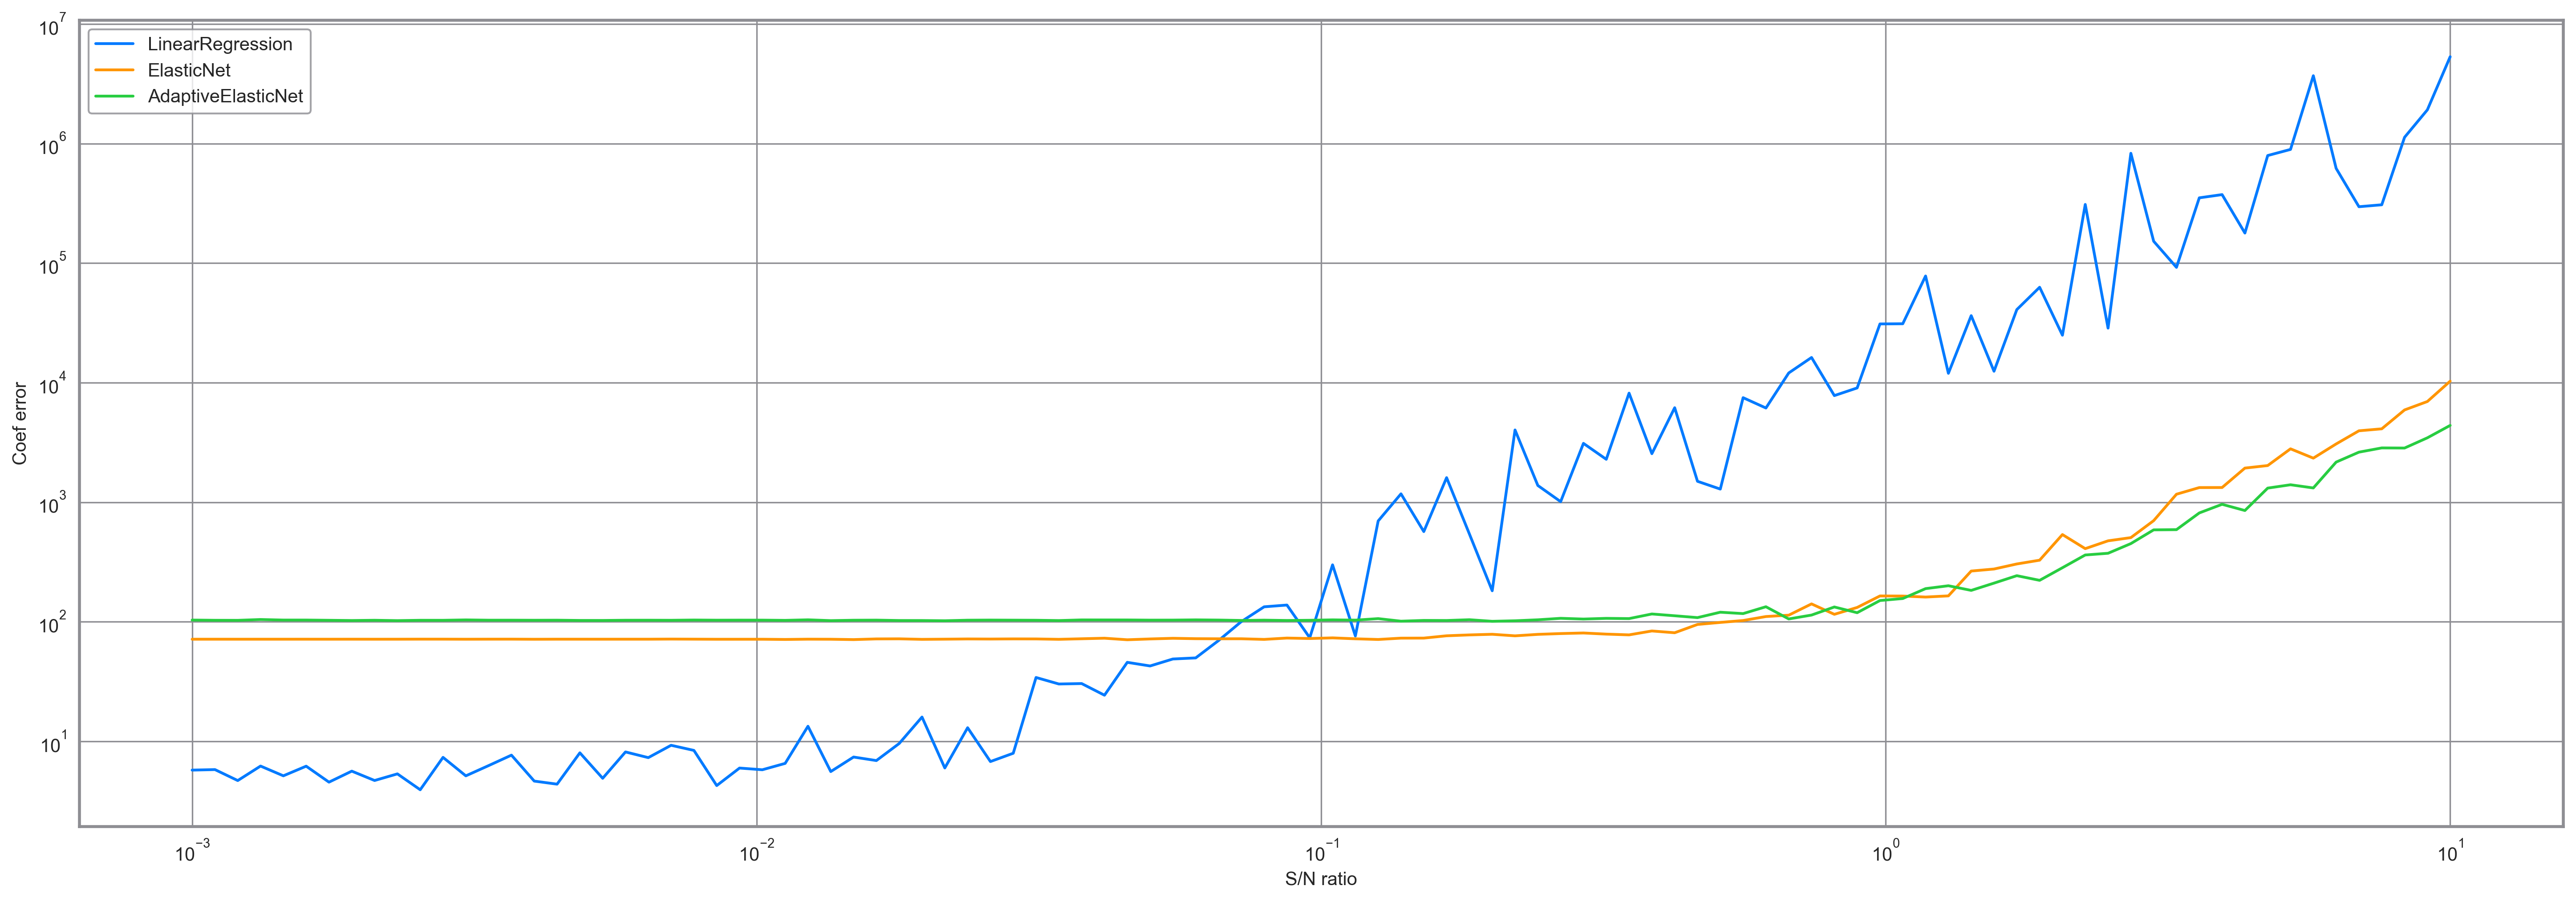

In [18]:
for model in models:
    sn_ratios = np.logspace(-3, 1, 100)
    coeferror = [
        score(model, sn_ratio=sn_ratio, score="coeferror") for sn_ratio in sn_ratios
    ]
    plt.plot(sn_ratios, coeferror, label=model.__class__.__name__)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("S/N ratio")
plt.ylabel("Coef error")
plt.show()

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


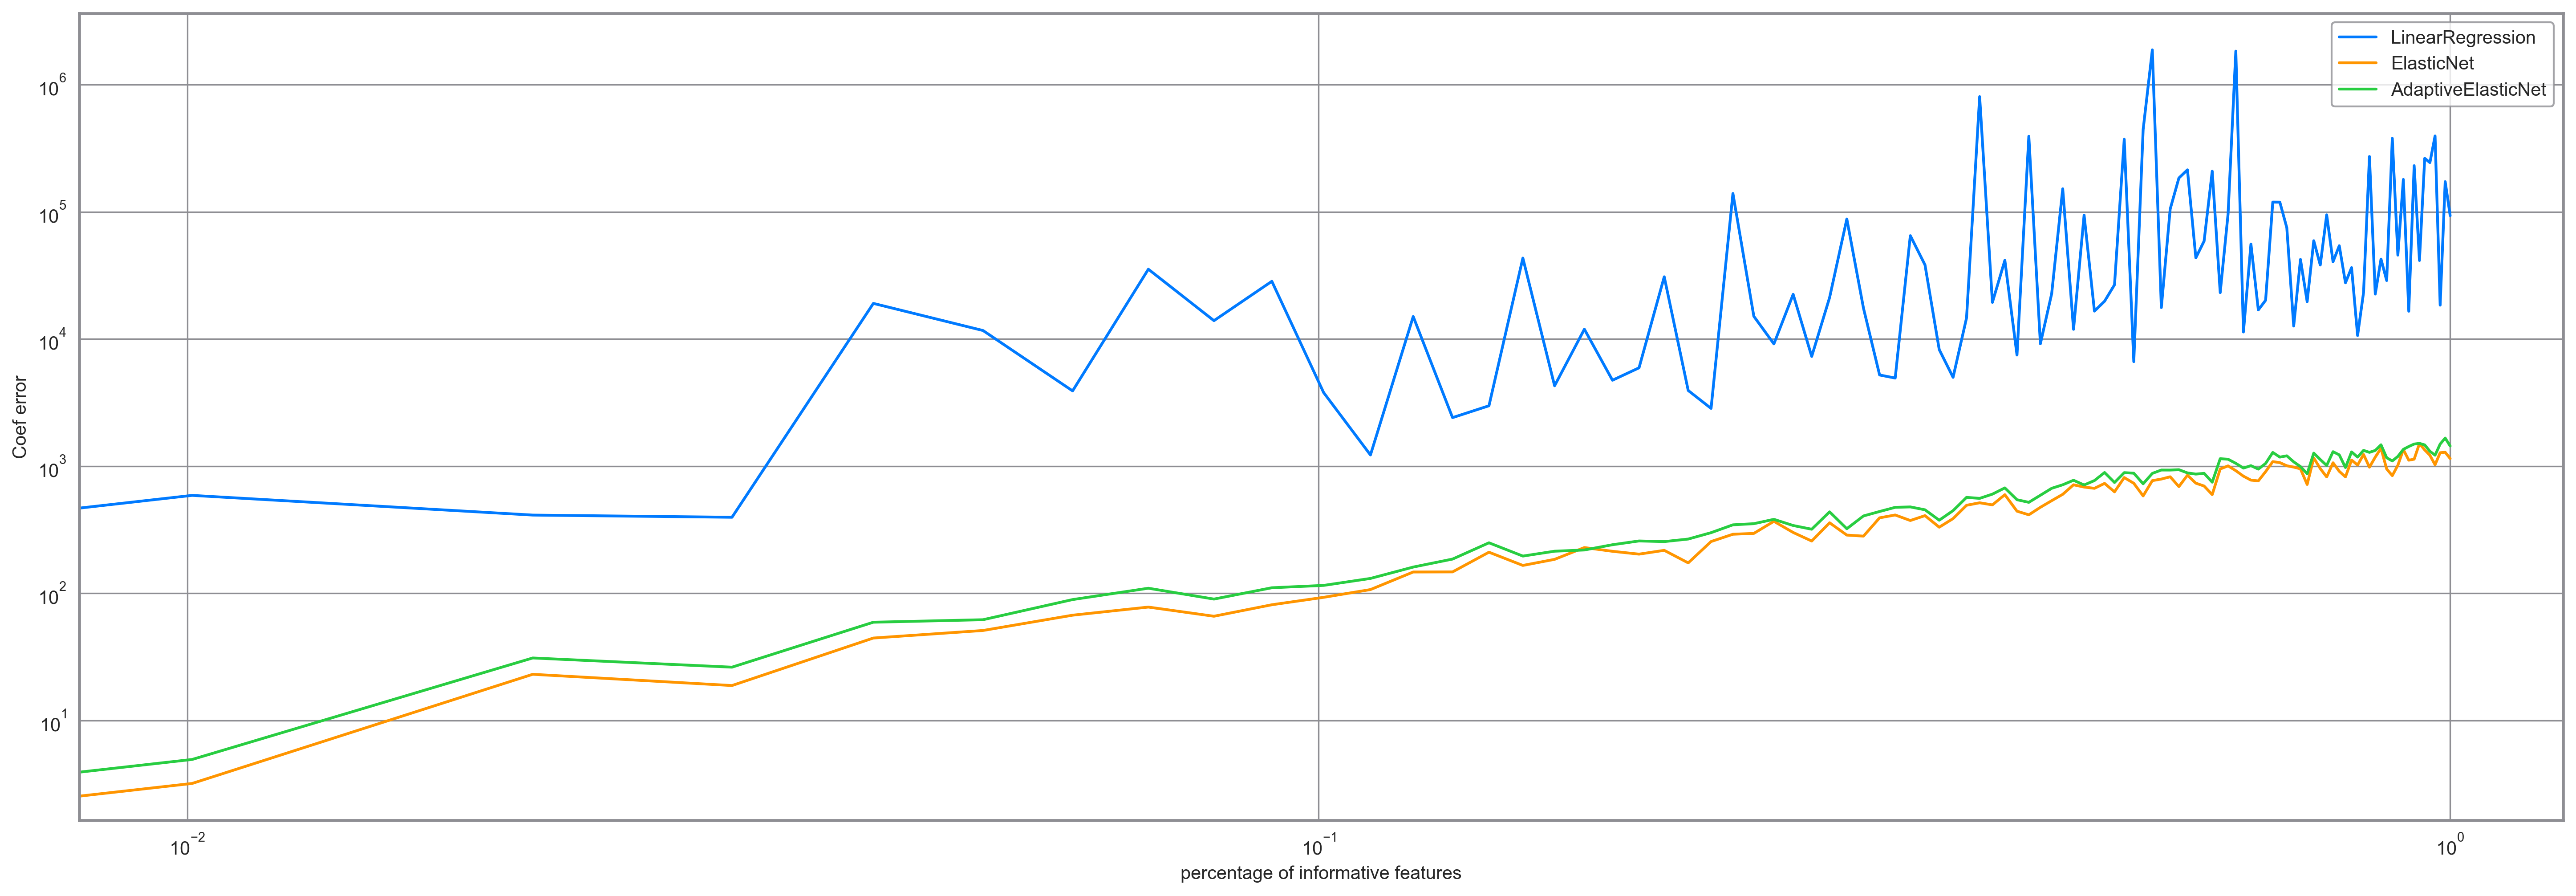

In [19]:
for model in models:
    r_informatives = np.linspace(0, 1, 100)
    y = [score(model, r_informative=x, score="coeferror") for x in r_informatives]
    plt.plot(r_informatives, y, label=model.__class__.__name__)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("percentage of informative features")
plt.ylabel("Coef error")
plt.show()

In [20]:
_X, _y = make_regression(n_samples=1000, n_features=1000, random_state=42)

In [21]:
model = models[0]
print(model.__class__.__name__)

LinearRegression


In [22]:
%%timeit
model.fit(_X, _y).predict(_X)

237 ms ± 7.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
model = models[1]
print(model.__class__.__name__)

ElasticNet


In [24]:
%%timeit
model.fit(_X, _y).predict(_X)

17.4 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
model = models[2]
print(model.__class__.__name__)

AdaptiveElasticNet


In [26]:
%%timeit
model.fit(_X, _y).predict(_X)

4.03 s ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
